# Data used in this notebook
- market_cap.csv
- portfolio_at.csv

In [239]:
import pandas as pd


In [240]:
market_cap=pd.read_csv('market_cap.csv') # monthly mktcap for each gvkey, with year and month num
market_cap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21692 entries, 0 to 21691
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PERMNO    21692 non-null  int64  
 1   MthCalDt  21692 non-null  object 
 2   MthCap    21692 non-null  float64
 3   gvkey     21692 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 678.0+ KB


In [241]:
# creat year and month
market_cap['MthCalDt'] = pd.to_datetime(market_cap['MthCalDt'], format='%Y/%m/%d')
market_cap['year'] = market_cap['MthCalDt'].dt.year
market_cap['month'] = market_cap['MthCalDt'].dt.month
market_cap = market_cap.drop(columns=['MthCalDt'])
print(market_cap.describe())
market_cap.to_csv('market_cap2.csv')
market_cap.tail()

             PERMNO        MthCap          gvkey          year         month
count  21692.000000  2.169200e+04   21692.000000  21692.000000  21692.000000
mean   77955.165775  4.584563e+06  153503.101835   2011.761110      6.515029
std    27012.647796  9.662385e+06   32019.133455      6.162657      3.457175
min    12009.000000  3.681480e+03  105365.000000   1996.000000      1.000000
25%    86316.000000  4.906814e+05  127575.000000   2007.000000      4.000000
50%    88917.000000  1.467253e+06  155394.000000   2012.000000      7.000000
75%    90870.000000  4.103633e+06  175404.000000   2017.000000     10.000000
max    93387.000000  1.332086e+08  315318.000000   2023.000000     12.000000


,PERMNO,MthCap,gvkey,year,month
21687,14406,3991535.37,315318,2022,9
21688,14406,4163879.20,315318,2022,10
21689,14406,4735202.16,315318,2022,11
21690,14406,4403544.34,315318,2022,12
21691,14406,4957921.28,315318,2023,1


In [222]:
import pandas as pd

# Assuming market_cap DataFrame is already defined and has columns: gvkey, year, month, MthCap

# Initialize empty DataFrame to store annual returns
merged_yret = pd.DataFrame()

# Group by gvkey
for gvkey in market_cap['gvkey'].unique():
    key_data = market_cap[market_cap['gvkey'] == gvkey]

    # Group by year within each gvkey
    for year in key_data['year'].unique():
        # Create a copy of the data for a specific year
        year_data = key_data[key_data['year'] == year].copy()

        # Calculate monthly returns
        year_data['mret'] = year_data['MthCap'].pct_change()*100

        # Calculate the cap-weighted annual return
        capsum = year_data['MthCap'][1:].sum()
        year_data['weighted_ret'] = 12 * year_data['mret'] * year_data['MthCap'] / capsum
        annual_return = year_data['weighted_ret'].sum()  # Sum of weighted returns

        # Create a dictionary to store the annual return
        yret = {'year': year, 'yret': annual_return, 'gvkey': gvkey, 'cap':capsum}

        # Append the dictionary as a DataFrame to merged_yret
        merged_yret = pd.concat([merged_yret, pd.DataFrame([yret])], ignore_index=True)

print(merged_yret)

merged_yret['gvkey'].describe()

      year         yret   gvkey          cap
0     1998  1177.469650  105365  13307748.01
1     1999   105.812920  105365  37580523.57
2     2000    59.309079  105365  70791431.33
3     2001   -89.784902  105365  35119531.42
4     2002   128.299763  105365   6977781.17
...    ...          ...     ...          ...
1956  2019    -1.160337  315318  29892556.32
1957  2020    79.527286  315318  31378829.64
1958  2021    41.337367  315318  60043243.37
1959  2022   -13.575284  315318  53104197.04
1960  2023     0.000000  315318         0.00

[1961 rows x 4 columns]


count      1961.000000
mean     153962.662927
std       32024.366393
min      105365.000000
25%      128978.000000
50%      157415.000000
75%      175689.000000
max      315318.000000
Name: gvkey, dtype: float64

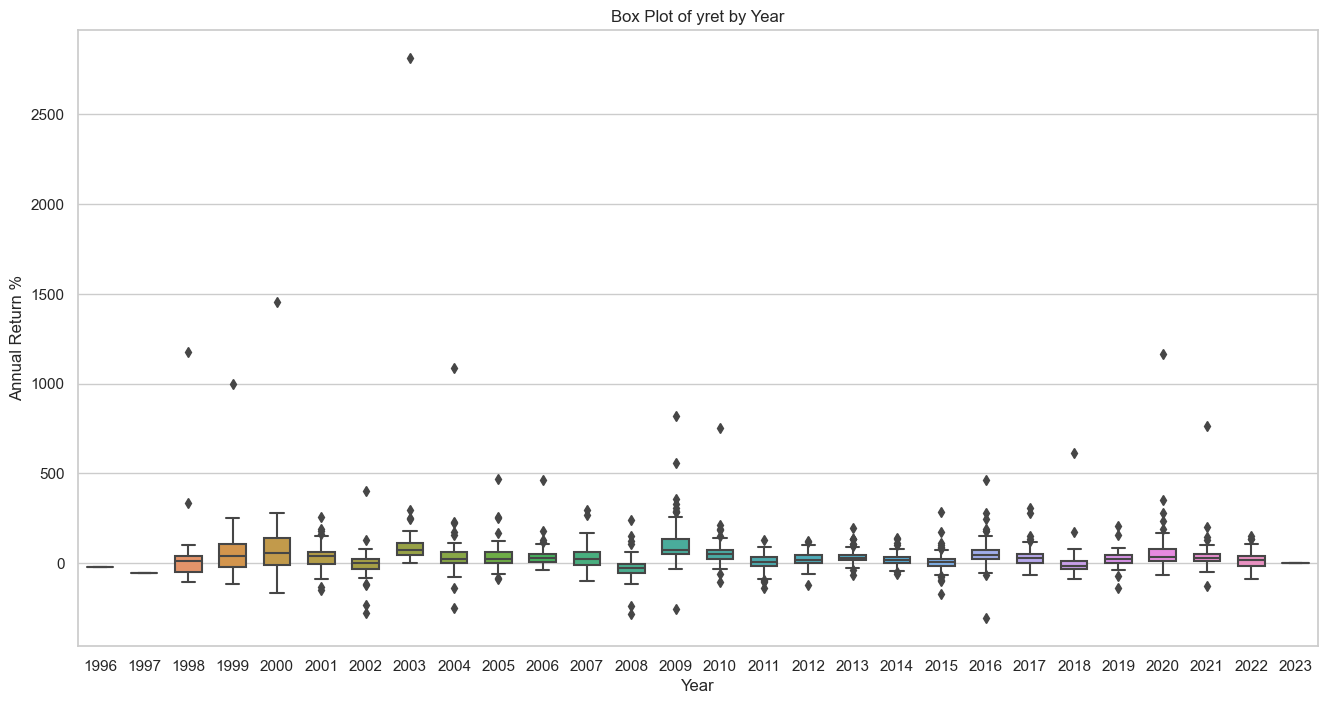

In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# visualization yret cross time
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.boxplot(x='year', y='yret', data=merged_yret, width=0.6)

plt.title('Box Plot of yret by Year')
plt.xlabel('Year')
plt.ylabel('Annual Return %')
plt.show()

In [224]:
portfolio_at = pd.read_csv('portfolio_at.csv')

In [225]:
has_missing_values = merged_yret['yret'].isna().any()
has_missing_values

False

In [226]:
at_df_yret = pd.merge(portfolio_at, merged_yret, how='inner', left_on=['fyear','gvkey'],right_on=['year','gvkey'])
# unify tag type to facilitate by group discuss
at_df_yret['group_tag'] = at_df_yret['group_tag'].astype(str)



In [227]:
# Risk free rate
rf = pd.read_excel('rfrm.xlsx')
rf['T.Bill Rate'] = rf['T.Bill Rate']*100
rf.rename(columns={'T.Bill Rate': 'rf'}, inplace=True)
at_df_yret = pd.merge(at_df_yret, rf, how='inner', left_on=['fyear'],right_on=['Year'])
at_df_yret = at_df_yret.drop(columns=['year','Year'])
at_df_yret['ret_prem'] = at_df_yret['yret']-at_df_yret['rf']

/Users/liuqiaochu/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [228]:
at_df_yret.to_csv('at_df_yret.csv', index=False)

In [229]:
at_df_yret

,fyear,gvkey,at,p_at,group_tag,trade,weight_l,weight_s,weight,yret,cap,rf,Implied ERP,ret_prem
0,1998,105365,207.585,337.731532,H,1,0.001124,-0.000000,0.001124,1177.469650,1.330775e+07,4.33,0.0226,1173.139650
1,1998,109084,102.806,1295.644223,H,1,0.000557,-0.000000,0.000557,-17.676991,2.163609e+06,4.33,0.0226,-22.006991
2,1998,109185,220.010,0.000000,L,-1,0.000000,-0.002642,-0.002642,34.530883,5.018442e+06,4.33,0.0226,30.200883
3,1998,110533,181.731,503.216292,2,0,0.000000,-0.000000,0.000000,-103.695093,1.856672e+06,4.33,0.0226,-108.025093
4,1998,110566,240.900,7.285181,3,0,0.000000,-0.000000,0.000000,-74.105404,1.639788e+06,4.33,0.0226,-78.435404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,2022,187550,369.685,13.607801,H,1,0.001051,-0.000000,0.001051,66.846619,7.068599e+06,4.42,0.0594,62.426619
1430,2022,187740,813.083,9.651905,L,-1,0.000000,-0.004631,-0.004631,23.805286,4.385416e+07,4.42,0.0594,19.385286
1431,2022,189491,3012.000,1.317983,L,-1,0.000000,-0.017154,-0.017154,18.006903,1.824886e+08,4.42,0.0594,13.586903
1432,2022,196159,6546.300,46.238966,L,-1,0.000000,-0.037283,-0.037283,136.399693,4.441843e+07,4.42,0.0594,131.979693


In [230]:
unique_count = at_df_yret['gvkey'].nunique()
print(unique_count)

133


In [243]:
group_counts = at_df_yret.groupby(['fyear', 'group_tag']).size().unstack(fill_value=0)
group_counts.to_excel('group_counts.xlsx',index = False)

In [231]:
import pandas as pd
import math

# Assuming rf is defined earlier in your code

# Initialize dictionaries to store results
group_ret = {}
group_std = {}
group_prem = {}

# Loop through each unique tag group
for tag in at_df_yret['group_tag'].unique():
    tag_data = at_df_yret[at_df_yret['group_tag'] == tag].copy()
    exp_ret_year = {}

    # Calculate expected return for each year
    for year in tag_data['fyear'].unique():
        year_data = tag_data[tag_data['fyear'] == year].copy()
        year_data['weight'] = year_data['cap'] / year_data['cap'].sum()
        year_return = (year_data['yret'] * year_data['weight']).sum()
        exp_ret_year[year] = year_return
        
    tag_data['exp_ret_year'] = tag_data['fyear'].map(exp_ret_year)
    tag_data['ret_prem'] = tag_data['exp_ret_year'] - tag_data['rf']
    group = tag_data[['fyear', 'ret_prem', 'exp_ret_year']].drop_duplicates()
    print(group,tag)
    
    # Calculate average yearly return for the group
    exp_ret = group['exp_ret_year'].sum() / len(group['exp_ret_year'])
    std = group['exp_ret_year'].std()/math.sqrt(len(group['exp_ret_year']))
    ret_prem = group['ret_prem'].sum()/ len(group['exp_ret_year'])

    # Store results in dictionaries
    group_ret[tag] = exp_ret
    group_std[tag] = std
    group_prem[tag] = ret_prem

    
    
# Create DataFrames from dictionaries
group_ret_df = pd.DataFrame.from_dict(group_ret, orient='index', columns=['Expected Annual Return %'])
group_std_df = pd.DataFrame.from_dict(group_std, orient='index', columns=['Std %'])
group_prem_df = pd.DataFrame.from_dict(group_prem, orient='index', columns=['Er-Rf %'])

# Merge DataFrames
group_feature = group_ret_df.merge(group_std_df, left_index=True, right_index=True)
group_feature = group_feature.merge(group_prem_df, left_index=True, right_index=True).round(2)

     fyear    ret_prem  exp_ret_year
0     1998  292.502427    296.832427
15    1999   36.703143     42.073143
35    2000   96.842810    102.572810
68    2001   -4.945708     -3.145708
108   2002   17.001645     18.201645
152   2003   72.622265     73.622265
185   2004   11.732819     13.912819
233   2005   20.195049     24.505049
305   2006   40.179569     45.059569
357   2007   31.962895     35.272895
422   2008  -34.150815    -32.560815
491   2009   78.738893     78.878893
569   2010   61.383297     61.513297
631   2011   10.954627     10.984627
710   2014    9.675963      9.728963
791   2015    3.709746      3.919746
869   2016   30.656434     31.166434
946   2012   35.294254     35.344254
1022  2013   25.450910     25.520910
1101  2017   25.819812     27.209812
1158  2018  -39.097384    -36.727384
1218  2019   33.185811     34.735811
1272  2020   45.051641     45.141641
1328  2021   49.130630     49.190630
1384  2022   -1.756046      2.663954 H
     fyear   ret_prem  exp_ret_year


In [238]:
# calculate t-statistics and Sharpe Ratio
index_order = ['L', '2', '3', '4', 'H']
group_feature = group_feature.reindex(index_order)
group_feature['t-stats'] = (group_feature['Expected Annual Return %'] / group_feature['Std %']).round(2)
group_feature['Sharpe Ratio'] = (group_feature['Er-Rf %'] / group_feature['Std %']).round(2)
group_feature.to_excel('feature_at.xlsx', index=False)
group_feature

,Expected Annual Return %,Std %,Er-Rf %,t-stats,Sharpe Ratio
L,31.95,4.81,30.08,6.64,6.25
2,26.95,5.99,25.08,4.50,4.19
3,41.26,15.10,39.39,2.73,2.61
4,30.15,5.70,28.38,5.29,4.98
H,39.82,12.42,37.95,3.21,3.06


In [233]:
import numpy as np

exp_ret_year_H = {}
# Filter the original DataFrame to include only rows where tag is 'H' or 'L'
H_df = at_df_yret[at_df_yret['group_tag'].isin(['H'])].copy()
for year in H_df['fyear'].unique():
    year_H = H_df[H_df['fyear'] == year].copy()
    year_H['weight'] = year_H['cap'] / year_H['cap'].sum()
    year_H_return = (year_H['yret'] * year_H['weight']).sum()
    exp_ret_year_H[year] = year_H_return

exp_ret_year_H = pd.DataFrame.from_dict(exp_ret_year_H, orient='index', columns=['ret_H'])    
exp_ret_year_H['rf'] = H_df.groupby('fyear')['rf'].first().values

exp_ret_year_L = {}
# Filter the original DataFrame to include only rows where tag is 'H' or 'L'
L_df = at_df_yret[at_df_yret['group_tag'].isin(['L'])].copy()
for year in L_df['fyear'].unique():
    year_L = L_df[L_df['fyear'] == year].copy()
    year_L['weight'] = year_L['cap'] / year_L['cap'].sum()
    year_L_return = (year_L['yret'] * year_L['weight']).sum()
    exp_ret_year_L[year] = year_L_return

exp_ret_year_L = pd.DataFrame.from_dict(exp_ret_year_L, orient='index', columns=['ret_L'])     

merged_df = pd.merge(exp_ret_year_H, exp_ret_year_L, left_index=True, right_index=True)

merged_df['H-L'] = merged_df['ret_H']- merged_df['ret_L']

print(merged_df['H-L'].mean())
print(merged_df['ret_H'].mean())
print(merged_df['ret_L'].mean())
# H_df['exp_ret_year'] = tag_data['fyear'].map(exp_ret_year)
# H_df['ret_prem'] = tag_data['exp_ret_year'] - tag_data['rf']

7.871352819728631
39.82470750683772
31.95335468710909


In [234]:
merged_df.reset_index(inplace=True)
merged_df.rename(columns={'index': 'year'}, inplace=True)


In [235]:
merged_df['H-L'] = merged_df['ret_H']- merged_df['ret_L']
merged_df['H-L_prem'] = merged_df['H-L']- merged_df['rf']

mean = merged_df['H-L'].mean()
std = merged_df['H-L'].std()/math.sqrt(len(merged_df['H-L']))
mean_prem = merged_df['H-L_prem'].mean()

In [236]:
merged_df.to_csv('at_HML.csv', index=False)

In [237]:
import pandas as pd

# Assuming mean, std, and mean_prem are numpy float64 values
mean_dict = {'HML': mean}
std_dict = {'HML': std}
mean_prem_dict = {'HML': mean_prem}

# Create DataFrames from dictionaries
HML_ret_df = pd.DataFrame.from_dict(mean_dict, orient='index', columns=['Expected Annual Return %'])
HML_std_df = pd.DataFrame.from_dict(std_dict, orient='index', columns=['Std %'])
HML_prem_df = pd.DataFrame.from_dict(mean_prem_dict, orient='index', columns=['Er-Rf %'])

# Merge DataFrames
HML_feature = HML_ret_df.merge(HML_std_df, left_index=True, right_index=True)
HML_feature = HML_feature.merge(HML_prem_df, left_index=True, right_index=True).round(2)

# Calculate t-statistics and Sharpe Ratio
HML_feature['t-stats'] = (HML_feature['Expected Annual Return %'] / HML_feature['Std %']).round(2)
HML_feature['Sharpe Ratio'] = (HML_feature['Er-Rf %'] / HML_feature['Std %']).round(2)
HML_feature

,Expected Annual Return %,Std %,Er-Rf %,t-stats,Sharpe Ratio
HML,7.87,12.92,6.0,0.61,0.46
